In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Moroo'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

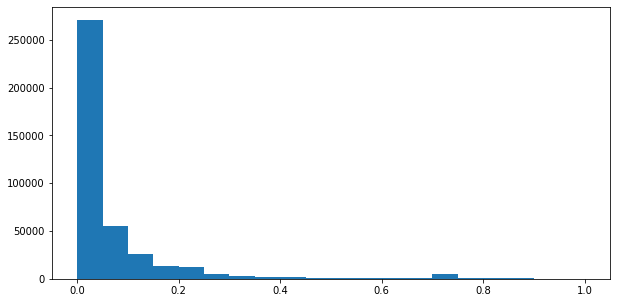

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

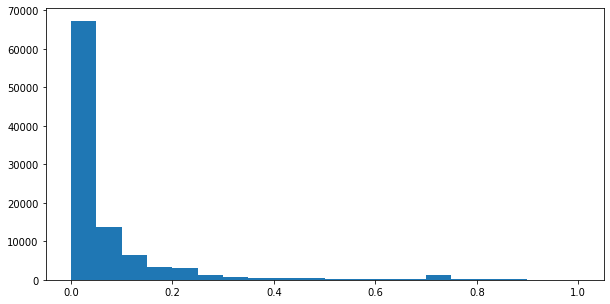

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'sigmoid'))
x.add(Dense(1024, activation = 'sigmoid'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model_baseline(shared_model, input_shape, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         7755776     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model_baseline(model, X_train, X_validation, Y_train, Y_validation, size_hash_vector, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 18s 21ms/step - loss: -0.4658 - manh_dist_loss: 0.0527 - abs_vect_loss: -0.9841 - abs_vect_1_loss: -0.9846 - manh_dist_rmse: 0.2296 - manh_dist_mae: 0.1421 - val_loss: -0.4813 - val_manh_dist_loss: 0.0278 - val_abs_vect_loss: -0.9904 - val_abs_vect_1_loss: -0.9904 - val_manh_dist_rmse: 0.1666 - val_manh_dist_mae: 0.1093
Epoch 2/20
781/781 [==============================] - 15s 19ms/step - loss: -0.4838 - manh_dist_loss: 0.0242 - abs_vect_loss: -0.9916 - abs_vect_1_loss: -0.9917 - manh_dist_rmse: 0.1555 - manh_dist_mae: 0.1018 - val_loss: -0.4849 - val_manh_dist_loss: 0.0230 - val_abs_vect_loss: -0.9928 - val_abs_vect_1_loss: -0.9929 - val_manh_dist_rmse: 0.1516 - val_manh_dist_mae: 0.0996
Epoch 3/20
781/781 [==============================] - 15s 19ms/step - loss: -0.4873 - manh_dist_loss: 0.0185 - abs_vect_loss: -0.9932 - abs_vect_1_loss: -0.9931 - manh_dist_rmse: 0.1359 - manh_dist_mae: 0.0894 - val_loss: -0.4881 - val_manh_dist_lo

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{Baseline}$

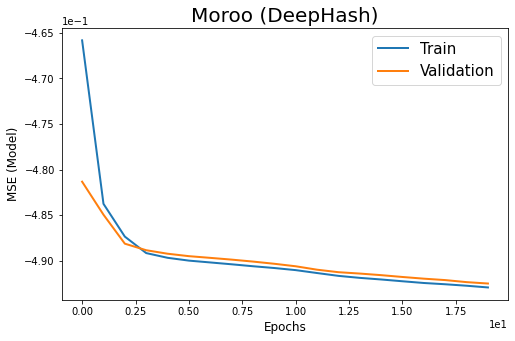

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history['loss'], linewidth = 2)
plt.plot(siamese_model.history['val_loss'], linewidth = 2)
plt.title('Moroo (CNNH+LSH)', fontsize = 20)
plt.ylabel('MSE (Model)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of Similarity preserving loss

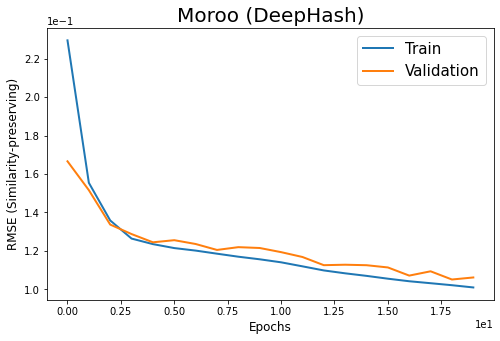

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Moroo (CNNH+LSH)', fontsize = 20)
plt.ylabel('RMSE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

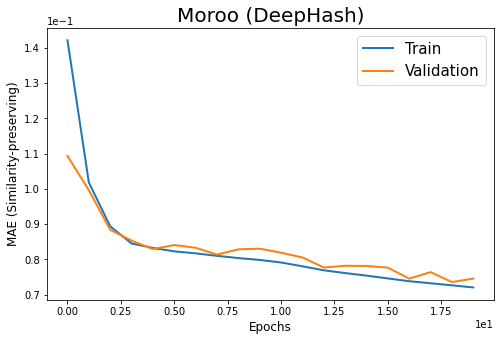

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Moroo (CNNH+LSH)', fontsize = 20)
plt.ylabel('MAE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.026, 0.071, 0.017, 0.331, 0.03 , 0.037, 0.299, 0.128, 0.036,
       0.055, 0.463, 0.142, 0.104, 0.024, 0.281, 0.023, 0.425, 0.096,
       0.048, 0.098, 0.269, 0.03 , 0.038, 0.148, 0.016, 0.017, 0.015,
       0.025, 0.126, 0.063, 0.282, 0.202, 0.14 , 0.031, 0.389, 0.048,
       0.207, 0.183, 0.071, 0.135, 0.185, 0.189, 0.077, 0.05 , 0.122,
       0.158, 0.254, 0.095, 0.214, 0.063], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.025, 0.   , 0.079, 0.   , 0.   , 0.151, 0.   , 0.008,
       0.   , 0.465, 0.096, 0.   , 0.   , 0.223, 0.   , 0.198, 0.   ,
       0.   , 0.037, 0.334, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.037, 0.176, 0.195, 0.164, 0.   , 0.432, 0.   ,
       0.058, 0.   , 0.   , 0.037, 0.04 , 0.134, 0.   , 0.   , 0.   ,
       0.073, 0.245, 0.054, 0.124, 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

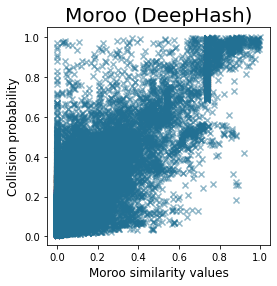

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Moroo (CNNH+LSH)', fontsize = 16)
plt.xlabel("Moroo similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/Baseline/Moroo-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.652913339464098

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.5089490288960663

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-baseline.model')

INFO:tensorflow:Assets written to: Models/model-deep-hash.model/assets


In [33]:
#intermediate_model = keras.models.load_model('Models/model-baseline.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [34]:
'First 64 bits'
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:64]

array([-0.9932256 ,  0.99425274, -0.9975583 ,  0.9999803 , -0.9999982 ,
        1.        , -0.99999833, -0.9992865 , -0.99938256, -0.9999971 ,
       -0.99832195,  1.        , -0.73821723,  0.7825293 ,  0.92537177,
       -0.99546874, -1.        ,  0.99589175,  0.9999985 , -0.9997969 ,
        0.99661404,  0.9987143 , -0.999769  , -0.7660741 ,  0.95131844,
       -0.999785  , -0.9607017 ,  0.81917256,  0.9858373 , -0.8780654 ,
       -0.999571  ,  0.986669  ,  1.        ,  0.99999905,  1.        ,
        0.9756086 ,  0.8115185 , -0.93633187, -0.99797803,  0.9999995 ,
        0.780809  , -0.757809  , -0.99933743, -1.        , -0.99961346,
        0.99999636, -0.9926618 , -1.        ,  0.8629836 , -0.92524844,
        0.9999141 ,  0.99094397,  0.9999906 , -0.9999098 , -0.9991492 ,
        0.99996465, -0.9995768 , -0.9995903 ,  0.99871063, -0.8608527 ,
       -0.9993063 ,  0.99999875, -1.        ,  0.9999261 ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [35]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [36]:
np.mean(np.abs(hash_vectors))

0.9113335

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [37]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.067849609375

### 3.3.4. Comparison between approximate hamming and real hamming

In [38]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

In [39]:
df_hamming

,embedding_stack_1,embedding_stack_2,hamming
0,"[-1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1...","[1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -...",0.000000
1,"[1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, ...","[1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -...",0.015625
2,"[1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -...","[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1,...",0.000000
3,"[1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -...","[1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1,...",0.312500
4,"[1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, ...","[1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -...",0.015625
...,...,...,...
99895,"[1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, ...","[-1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1,...",0.031250
99896,"[1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, ...","[1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -...",0.000000
99897,"[1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -...","[1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -...",0.421875
99898,"[1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -...","[1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -...",0.140625


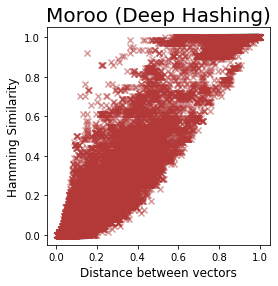

In [40]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Distance between vectors", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Moroo (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/Moroo-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [41]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [42]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)

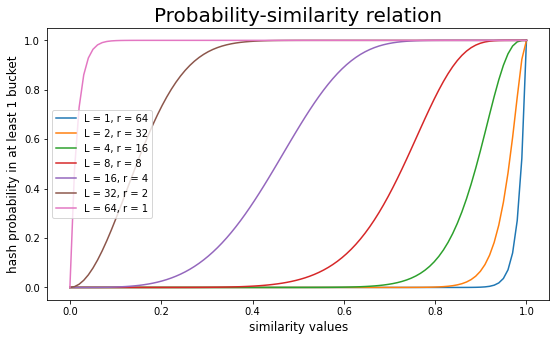

In [43]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 20)
plt.legend()

In [44]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Moroo', trace = False)

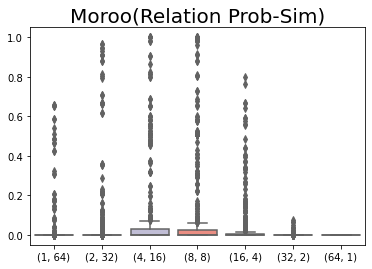

In [45]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.title('Moroo(Relation Prob-Sim)', fontsize = 20)
plt.savefig('Results/Baseline/Moroo-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [46]:
'L = K = 8'
L, K = params[3]
L, K

(8, 8)

### 4.1.1 Mean and Median probability for all stack traces for the best combination of $K$ and $L$

In [ ]:
df_probLSH.mean()['(8, 8)']

In [ ]:
df_probLSH.median()['(8, 8)']

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [47]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [48]:
with open('Hash-Tables/hash_tables_baseline.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [49]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

187

In [50]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{19,
 35,
 57,
 61,
 65,
 74,
 164,
 187,
 200,
 203,
 210,
 274,
 275,
 287,
 306,
 322,
 382,
 416,
 766,
 832,
 835}

In [51]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [52]:
near_duplicates_sim = df_measures['Moroo'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

34521     1.000000
150492    0.914379
170069    0.914190
169437    0.909588
169556    0.883351
170000    0.822275
170066    0.796686
169650    0.790200
169540    0.767000
55476     0.764084
18977     0.759944
71337     0.750346
59234     0.745672
62976     0.745672
169434    0.740126
169616    0.722684
169509    0.708664
169508    0.697034
169444    0.642413
169521    0.550152
Name: Moroo, dtype: float64

In [53]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Moroo', n_stacks, n_duplicate_pairs)
set_real_nns

{19,
 35,
 57,
 61,
 65,
 74,
 164,
 200,
 203,
 210,
 274,
 275,
 306,
 322,
 382,
 416,
 526,
 766,
 832,
 835}

In [54]:
real_nns_sim[:n_duplicate_pairs]

34521     1.000000
150492    0.914379
170069    0.914190
169437    0.909588
169556    0.883351
170000    0.822275
170066    0.796686
169650    0.790200
169540    0.767000
55476     0.764084
18977     0.759944
71337     0.750346
59234     0.745672
62976     0.745672
169434    0.740126
169616    0.722684
169509    0.708664
169508    0.697034
169444    0.642413
169760    0.592597
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [55]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Moroo')

0.745

In [ ]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Moroo')

-----------------------------------------------------------------

In [56]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Moroo')

0.6863333333333352

In [ ]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Moroo')

-----------------------------------------------------------------

In [57]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Moroo')

0.6774000000000016

In [ ]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Moroo')

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [ ]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

In [58]:
df_knns = mean_generalized_mrr(n_stacks, params[3:4], hash_vectors_hamming, b, df_measures ,'Moroo', trace = False)
df_knns.mean(skipna = True, axis = 0)

(8, 8)    0.643787
dtype: float64

In [ ]:
df_knns.mean()['(8, 8)']

### 4.4.3. Recall w.r.t. LSH

In [62]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Moroo', trace = False)
df_recall.mean(skipna = True)

(1, 64)    0.956522
(2, 32)    0.956522
(4, 16)    0.857178
(8, 8)     0.857974
(16, 4)    0.685112
(32, 2)    0.445931
(64, 1)    0.643112
dtype: float64

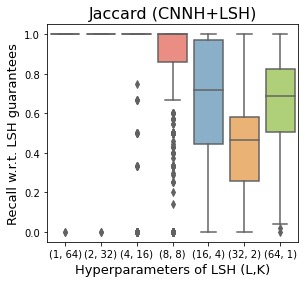

In [63]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('Moroo (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precison w.r.t. LSH

In [64]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Moroo', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.039929
(2, 32)    0.030659
(4, 16)    0.203952
(8, 8)     0.662178
(16, 4)    0.709862
(32, 2)    0.806549
(64, 1)    0.838740
dtype: float64

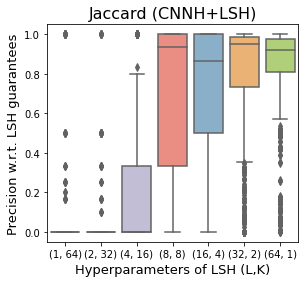

In [65]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('Moroo (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [66]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.045766
(2, 32)    0.037732
(4, 16)    0.236304
(8, 8)     0.650948
(16, 4)    0.628756
(32, 2)    0.522593
(64, 1)    0.699809
dtype: float64

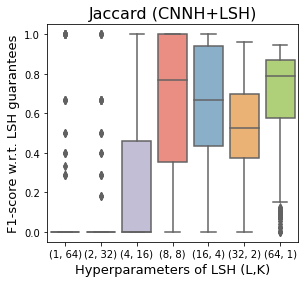

In [67]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('Moroo (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/fscore-LSH', bbox_inches='tight')
plt.show()